In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard
%matplotlib inline

In [16]:
from rfe import df_selected

In [17]:
df_selected = df_selected.sort_values(by='date',ascending=False)

In [18]:
training_set = df_selected.drop(columns=['date']).values
datelist_train = list(df_selected['date'])

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 0.09448686],
       [ 0.09976683],
       [ 0.14253456],
       ...,
       [-0.66028445],
       [-0.69787782],
       [-0.77142776]])

In [20]:
X_train = []
y_train = []

n_future = 14   # Number of days we want top predict into the future
n_past = 60     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df_selected.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1686, 60, 2).
y_train shape == (1686, 1).


In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [22]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=50,activation='sigmoid', return_sequences=True, input_shape=(n_past, df_selected.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=50,activation='tanh', return_sequences=False))

# Adding Dropout
model.add(Dropout(0.1))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mse')

In [23]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=150, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=2, batch_size=4)

Epoch 1/150

Epoch 1: val_loss improved from inf to 0.01266, saving model to weights.h5
337/337 - 11s - loss: 0.2004 - val_loss: 0.0127 - lr: 0.0100 - 11s/epoch - 33ms/step
Epoch 2/150

Epoch 2: val_loss did not improve from 0.01266
337/337 - 6s - loss: 0.0584 - val_loss: 0.0234 - lr: 0.0100 - 6s/epoch - 17ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 0.01266
337/337 - 6s - loss: 0.0545 - val_loss: 0.0298 - lr: 0.0100 - 6s/epoch - 18ms/step
Epoch 4/150

Epoch 4: val_loss improved from 0.01266 to 0.00853, saving model to weights.h5
337/337 - 6s - loss: 0.0538 - val_loss: 0.0085 - lr: 0.0100 - 6s/epoch - 18ms/step
Epoch 5/150

Epoch 5: val_loss did not improve from 0.00853
337/337 - 6s - loss: 0.0522 - val_loss: 0.0096 - lr: 0.0100 - 6s/epoch - 16ms/step
Epoch 6/150

Epoch 6: val_loss did not improve from 0.00853
337/337 - 6s - loss: 0.0522 - val_loss: 0.0209 - lr: 0.0100 - 6s/epoch - 16ms/step
Epoch 7/150

Epoch 7: val_loss did not improve from 0.00853
337/337 - 6s - loss:

In [28]:
datelist_future = pd.date_range(datelist_train[1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

print(datelist_future)

[Timestamp('2024-03-17 00:00:00'), Timestamp('2024-03-18 00:00:00'), Timestamp('2024-03-19 00:00:00'), Timestamp('2024-03-20 00:00:00'), Timestamp('2024-03-21 00:00:00'), Timestamp('2024-03-22 00:00:00'), Timestamp('2024-03-23 00:00:00'), Timestamp('2024-03-24 00:00:00'), Timestamp('2024-03-25 00:00:00'), Timestamp('2024-03-26 00:00:00'), Timestamp('2024-03-27 00:00:00'), Timestamp('2024-03-28 00:00:00'), Timestamp('2024-03-29 00:00:00'), Timestamp('2024-03-30 00:00:00')]


In [29]:
predictions_future = model.predict(X_train[-n_future:])
print(predictions_future)

predictions_train = model.predict(X_train[n_past:]) 


1/1 [==============================] - 0s 25ms/step
[[-0.6214144 ]
 [-0.6748079 ]
 [-0.74567497]
 [-0.7285125 ]
 [-0.71933055]
 [-0.6951562 ]
 [-0.6945288 ]
 [-0.74241066]
 [-0.7203219 ]
 [-0.6767551 ]
 [-0.65733516]
 [-0.71120775]
 [-0.71320057]
 [-0.7465439 ]]
51/51 [==============================] - 0s 9ms/step


In [30]:

def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)
print(y_pred_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)
PREDICTIONS_FUTURE.tail()


[[615.07623]
 [619.3705 ]
 [616.4925 ]
 ...
 [263.40536]
 [263.02795]
 [256.7129 ]]


,Close
2024-03-26,269.930542
2024-03-27,273.608582
2024-03-28,263.405365
2024-03-29,263.027954
2024-03-30,256.712891


KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'

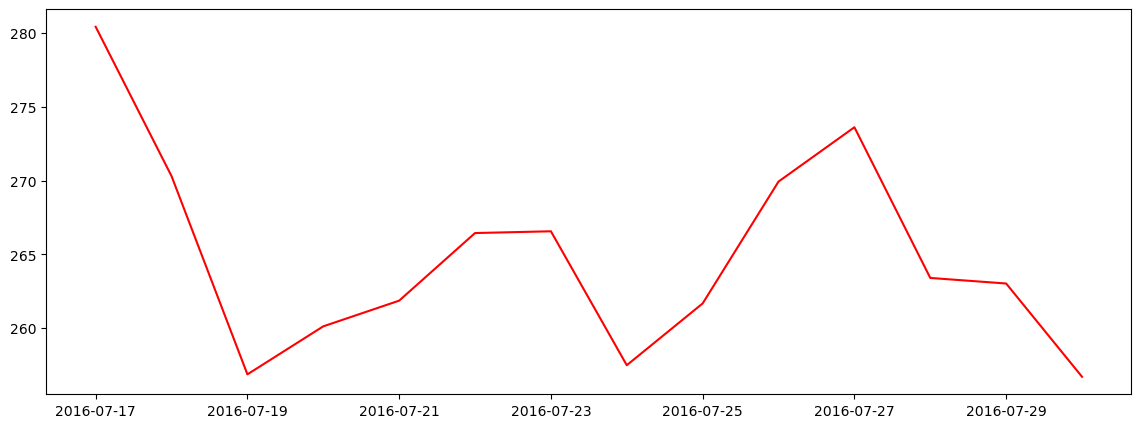

In [27]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Close'], color='orange', label='Training predictions')
plt.plot(df_selected.loc[START_DATE_FOR_PLOTTING:].index, df_selected.loc[START_DATE_FOR_PLOTTING:]['Close'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()